# Setup

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
if IN_COLAB:
    !pip install -q scikit-learn
    !pip install -q einops jaxtyping
    !pip install -q transformers tokenizers
    !pip install -q transformer_lens circuitsvis

In [3]:
from dataclasses import dataclass
import random
import gc
from pathlib import Path
import functools

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import torch as t
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from scipy.optimize import curve_fit

import einops
from tqdm.notebook import tqdm #progress bars
from typing import Tuple, List, Optional, Dict
from jaxtyping import Float, Int, Bool
from torch import Tensor

from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast

import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output
import circuitsvis as cv

import h5py
import palettable

device = t.device("cuda" if t.cuda.is_available() else "cpu")
if IN_COLAB:
    rootdir=Path('/content/drive/MyDrive/AI/plusminus/')
    traindir = rootdir/'trained_models/'
else:
    rootdir=Path('./')
    traindir=rootdir/'training_data/'
figdir = rootdir/'figures/'
print('using device: ', device)
print('rootdir is: ', rootdir)

using device:  cpu
rootdir is:  .


# Tokenizer

In [4]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file=str(traindir/'tokenizer_2digit.json'), add_bos_token=True, name_or_path='2digit')
vocab = tokenizer.get_vocab()

# Model

In [5]:
@dataclass
class Config():
  d_vocab: int = len(tokenizer.get_vocab().keys())
  d_model: int = len(tokenizer.get_vocab().keys())
  d_mlp: int = 72
  n_heads: int = 8
  d_head: int = 18
  n_ctx: int = 6 #(N)(-)(N)(=)(+/-)(N)
  n_layers: int = 1

def build_hooked_transformer(cfg: Config, attn_only=False, one_hot_encode=True, norm_type='LN', **kwargs):

    hkconfig = HookedTransformerConfig(
        n_layers = cfg.n_layers,
        d_model = cfg.d_model,
        n_ctx = cfg.n_ctx,
        d_head = cfg.d_head,
        n_heads = cfg.n_heads,
        act_fn = 'relu',
        attn_only=attn_only,
        normalization_type=norm_type,
        **kwargs
    )
    model =  HookedTransformer(cfg = hkconfig, tokenizer=tokenizer)

    if attn_only:
        #Remove biases from attention heads for direct comparison with math framework paper.
        for layer in model.blocks:
            layer.attn.b_K.requires_grad = False
            layer.attn.b_O.requires_grad = False
            layer.attn.b_Q.requires_grad = False
            layer.attn.b_V.requires_grad = False

    if one_hot_encode:
        if cfg.d_model != len(tokenizer.get_vocab().keys()):
            raise ValueError("d_model != d_vocab, but that is required for one-hot encoding.")
        model.embed.W_E.requires_grad = False
        model.embed.W_E[:] = t.eye(cfg.d_model, cfg.d_model)
        model.unembed.W_U.requires_grad = False
        model.unembed.b_U.requires_grad = False
        model.unembed.W_U[:] = t.eye(cfg.d_model, cfg.d_model)
    return model

In [6]:
# Model Config
d_vocab = len(tokenizer.get_vocab().keys())
d_model = 128
n_head = 4
d_head = d_model // n_head
d_mlp  = 4 * d_model
n_layers = 1
attn_only = False
one_hot_encode = False
cfg = Config(n_layers=n_layers, d_model=d_model, n_heads=n_head, d_mlp=d_mlp, d_head=d_head)

# Load Model
tfm = build_hooked_transformer(cfg, attn_only=attn_only, one_hot_encode=one_hot_encode, norm_type=None)
tfm.to(device)
tokenizer = tfm.tokenizer
filename = traindir/'mlp_2digit_subtraction_nlayer1_nheads4_dmodel128_dhead32_seed12466689936998274052.pt'
tfm.load_state_dict(t.load(filename, map_location=device))

Moving model to device:  cpu


<All keys matched successfully>

In [7]:
# It's good to define helper variables
W_O = tfm.W_O[0]
W_K = tfm.W_K[0]
W_Q = tfm.W_Q[0]
W_V = tfm.W_V[0]
W_in = tfm.W_in[0]
W_out = tfm.W_out[0]
W_pos = tfm.W_pos
W_E = tfm.W_E
W_U = tfm.W_U

print('W_O  ', tuple(W_O.shape))
print('W_K  ', tuple(W_K.shape))
print('W_Q  ', tuple(W_Q.shape))
print('W_V  ', tuple(W_V.shape))
print('W_in ', tuple(W_in.shape))
print('W_out', tuple(W_out.shape))
print('W_pos', tuple(W_pos.shape))
print('W_E  ', tuple(W_E.shape))
print('W_U  ', tuple(W_U.shape))

W_O   (4, 32, 128)
W_K   (4, 128, 32)
W_Q   (4, 128, 32)
W_V   (4, 128, 32)
W_in  (128, 512)
W_out (512, 128)
W_pos (6, 128)
W_E   (103, 128)
W_U   (128, 103)


# Data

In [8]:
class DataHolder:

    def __init__(self, train_frac=0.3, batch_size=128):

        data = self.get_dataset()
        self.strs = self.build_strings(data)
        self.tok = self.encode(self.strs)

    def get_dataset(self):
        data = t.Tensor([(i,j) for i in range(100) for j in range(100)])
        results = data[:,:1] - data[:,-1:]
        return t.cat((data, results), dim=1).to(t.int64)

    def build_strings(self, nums: Tensor):
        iterable = zip(nums[:,0], nums[:,1], nums[:,2])
        data = [f'{n1}-{n2}={res:+d}' for n1,n2,res in iterable]
        return data

    def encode(self, str_data):
        return t.Tensor(tokenizer.batch_encode_plus(str_data).input_ids).to(t.int64)

data = DataHolder()
print(data.strs[:10])
print(data.strs[::333], data.tok[::333])

['0-0=+0', '0-1=-1', '0-2=-2', '0-3=-3', '0-4=-4', '0-5=-5', '0-6=-6', '0-7=-7', '0-8=-8', '0-9=-9']
['0-0=+0', '3-33=-30', '6-66=-60', '9-99=-90', '13-32=-19', '16-65=-49', '19-98=-79', '23-31=-8', '26-64=-38', '29-97=-68', '33-30=+3', '36-63=-27', '39-96=-57', '43-29=+14', '46-62=-16', '49-95=-46', '53-28=+25', '56-61=-5', '59-94=-35', '63-27=+36', '66-60=+6', '69-93=-24', '73-26=+47', '76-59=+17', '79-92=-13', '83-25=+58', '86-58=+28', '89-91=-2', '93-24=+69', '96-57=+39', '99-90=+9'] tensor([[  0, 101,   0, 102, 100,   0],
        [  3, 101,  33, 102, 101,  30],
        [  6, 101,  66, 102, 101,  60],
        [  9, 101,  99, 102, 101,  90],
        [ 13, 101,  32, 102, 101,  19],
        [ 16, 101,  65, 102, 101,  49],
        [ 19, 101,  98, 102, 101,  79],
        [ 23, 101,  31, 102, 101,   8],
        [ 26, 101,  64, 102, 101,  38],
        [ 29, 101,  97, 102, 101,  68],
        [ 33, 101,  30, 102, 100,   3],
        [ 36, 101,  63, 102, 101,  27],
        [ 39, 101,  96, 102

# Baseline model performance

In [9]:
def get_accuracy(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    logit_preds = logits[:, 3:-1, :].argmax(dim=-1) #5-digit
    acc = (logit_preds == tokens[:, 4:]).to(t.float)
    return acc.mean(dim=meandim)

def get_loss(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = log_probs[:, 3:-1].gather(dim=-1, index=tokens[:, 4:].unsqueeze(-1)).squeeze(-1) #5-digit
    return -log_probs_for_tokens.mean(dim=meandim)


In [10]:
original_logits, cache = tfm.run_with_cache(data.tok)
# Final 2 positions: (+/-) and number. Also remove the logits for `=`
original_loss = get_loss(original_logits, data.tok, meandim=0) #loss by digit
original_acc  = get_accuracy(original_logits, data.tok, meandim=0)
original_logits = original_logits[:, -2:, :-1]
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")

Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%


# Direct logit contributions

In [11]:
x0 = cache['resid_pre', 0]
delta_attn = cache['resid_mid', 0] - x0
delta_mlp = cache['resid_post', 0] - x0 - delta_attn

W_U_correct_tokens = W_U[:, data.tok[:,1:]][:,:,3]
direct = einops.einsum(W_U_correct_tokens, x0[:,3,:],
                            "d_model batch, batch d_model -> batch")
attn = einops.einsum(W_U_correct_tokens, delta_attn[:,3,:],
                            "d_model batch, batch d_model -> batch")
mlp = einops.einsum(W_U_correct_tokens, delta_mlp[:,3,:],
                            "d_model batch, batch d_model -> batch")
sum = direct + attn + mlp

print((direct/sum).max())
print((attn/sum).max())
print((mlp/sum).max())

print((direct/sum).min())
print((attn/sum).min())
print((mlp/sum).min())

tensor(0.1803, grad_fn=<MaxBackward1>)
tensor(0.1347, grad_fn=<MaxBackward1>)
tensor(0.9911, grad_fn=<MaxBackward1>)
tensor(0.0028, grad_fn=<MinBackward1>)
tensor(-0.0071, grad_fn=<MinBackward1>)
tensor(0.6850, grad_fn=<MinBackward1>)


# Important matrices and assumptions

### Q and K Biases don't matter

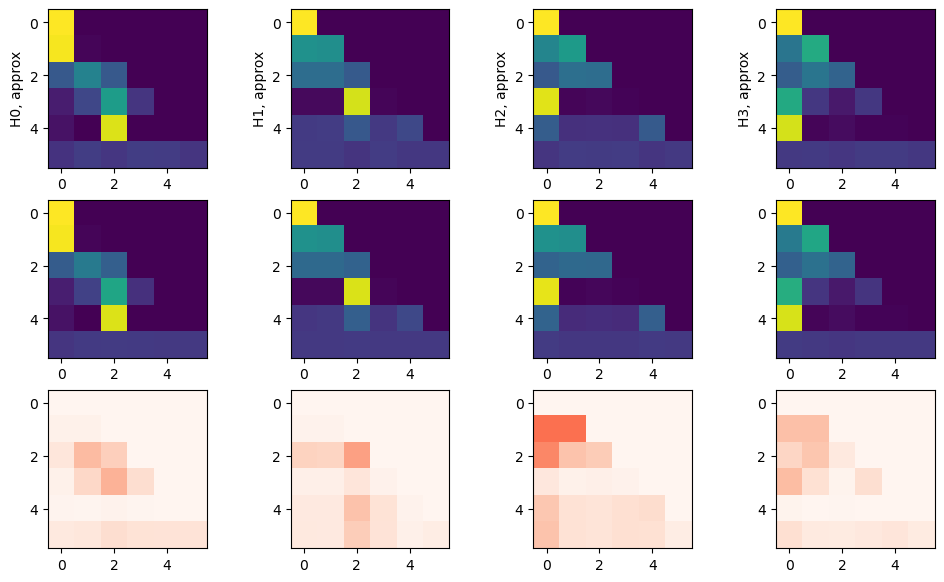

In [12]:
def apply_causal_mask(
        attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        '''
        Applies a causal mask to attention scores, and returns masked scores.
        '''
        # SOLUTION
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, tfm.blocks[0].attn.IGNORE)
        return attn_scores

attn_patt = cache['pattern', 0, 'attn']
x0 = cache['resid_pre', 0]
q = einops.einsum(x0, W_Q, 'batch seq d_model, n_head d_model d_head -> batch seq n_head d_head')# + tfm.b_Q
k = einops.einsum(x0, W_K, 'batch seq d_model, n_head d_model d_head -> batch seq n_head d_head')# + tfm.b_K
qk = einops.einsum(q, k, 'b q nh dh, b k nh dh -> b nh q k')
patt = F.softmax(apply_causal_mask(qk)/np.sqrt(tfm.cfg.d_head), dim=-1)

fig, axs = plt.subplots(3, 4, figsize=(12,7))
for i in range(4):
    axs[0][i].imshow(patt[0,i].detach().numpy(), vmin=0, vmax=1)
    axs[1][i].imshow(attn_patt[0,i].detach().numpy(), vmin=0, vmax=1)
    axs[2][i].imshow(np.sqrt(((attn_patt[:,i] - patt[:,i]).detach().numpy()**2).mean(axis=0)), vmin=0, vmax=1e-1, cmap='Reds')
    axs[0][i].set_ylabel('H{}, approx'.format(i))
    axs[0][i].set_ylabel('H{}, approx'.format(i))

### Can we ablate heads without loss of accuracy? -> not for +/- token, yes for number.

In [13]:
def ablate_attn_head(
    attn_patt: Float[Tensor, "batch seq n_head d_head"],
    hook: HookPoint,
    head: int = 0
) -> Float[Tensor, "batch seq n_head d_head"]:
    attn_patt[:,:,head] = t.mean(attn_patt, dim=2).mean(dim=0,keepdim=True)

for i in range(4):
    # print(cache)
    ablate_head = functools.partial(ablate_attn_head, head=i)
    ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                    (utils.get_act_name("blocks.0.attn.hook_z"), ablate_head)
                ])
    ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
    ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)
    
    print('Ablating head {}'.format(i))
    print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
    print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating head 0
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 1.3946854 10.801869 ], Ablated acc: [89.69  1.02]%
Ablating head 1
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [3.7781804 0.0292924], Ablated acc: [83.76 99.57]%
Ablating head 2
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [4.074169   0.02018111], Ablated acc: [83.48 99.93]%
Ablating head 3
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 1.7944238 11.955465 ], Ablated acc: [89.380005  0.97    ]%


### Position 3 embedding is same as = sign embedding -> it's fine to just use W_E for W_attn.

In [14]:
print(((W_E[tokenizer.get_vocab()['=']] - W_pos[3])**2).mean()) #MSE ~ 0

tensor(3.4611e-13, grad_fn=<MeanBackward0>)


### Modify tokens to account for position
Makes it so that W_neur can be defined with just W_E -- but when we interpret we need to remember that the token is not quite one-hot encoded!!

Well -- sort of. We can break it up into a constant thing that's ALWAYS there, then we can 

In [15]:
W_E_inv = t.Tensor(np.linalg.pinv(W_E.detach().numpy()))

def approx_posembed_hook(
    embedding: Float[Tensor, "batch seq d_model"],
    hook: HookPoint,
) -> Float[Tensor, "batch seq d_model"]:
    embedding[:,:,:] = (einops.einsum(W_pos, W_E_inv, W_E, 'seq imodel, imodel vocab, vocab model -> seq model'))[None,:]


ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), approx_posembed_hook)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Approximating positional embed]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Approximating positional embed]
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.0684856  0.01810083], Ablated acc: [98.549995 99.94    ]%


In [16]:
true_tok = t.zeros((data.tok.shape[0], data.tok.shape[1], W_E.shape[0]))
for i,tok in enumerate(data.tok):
    for j, tind in enumerate(tok):
        true_tok[i,j,tind] = 1
position_toks = einops.einsum(tfm.W_pos, W_E_inv, 'seq imodel, imodel vocab -> seq vocab')
mod_tok = true_tok + position_toks

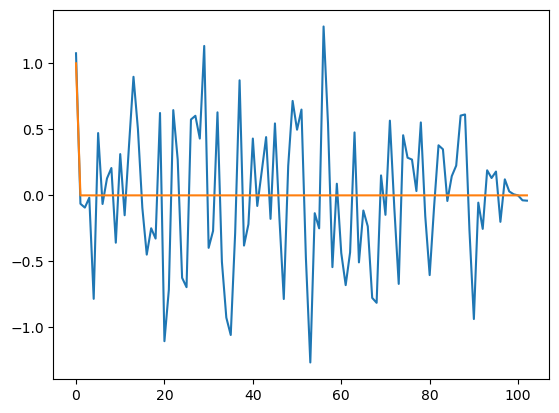

In [17]:
plt.plot(mod_tok[0,0,:].detach().numpy())
plt.plot(true_tok[0,0,:].detach().numpy())

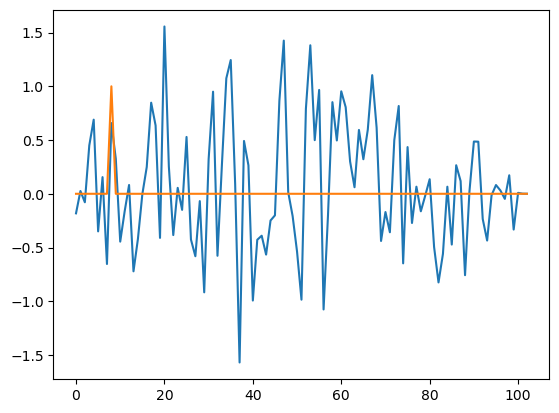

In [18]:
plt.plot(mod_tok[8,2,:].detach().numpy())
plt.plot(true_tok[8,2,:].detach().numpy())

### Do we need any other biases? (b_V, b_O, b_in, b_out)?

In [19]:
def ablate_bias(
    vals: Float[Tensor, "batch seq n_head d_head"],
    hook: HookPoint
) -> Float[Tensor, "batch seq n_head d_head"]:
    vals -= tfm.b_V

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.attn.hook_v"), ablate_bias)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating b_V'.format(i))
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating b_V
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.31551954 0.0204126 ], Ablated acc: [95.71 99.94]%


In [20]:
def ablate_bias(
    vals: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_model"]:
    vals -= tfm.b_O

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_attn_out"), ablate_bias)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating b_O'.format(i))
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating b_O
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.08640012 0.01892112], Ablated acc: [98.25 99.94]%


In [21]:
def ablate_bias(
    vals: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    vals -= tfm.b_in

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_bias)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating b_in'.format(i))
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating b_in
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07248662 0.01776718], Ablated acc: [98.36 99.94]%


In [22]:
def ablate_bias(
    vals: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_model"]:
    vals -= tfm.b_out

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_mlp_out"), ablate_bias)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating b_out'.format(i))
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating b_out
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06832373 0.01805187], Ablated acc: [98.57 99.94]%


### Matrix definitions

In [23]:
W_logit = einops.einsum(tfm.W_out[0], tfm.W_U, "d_mlp d_model, d_model d_vocab -> d_mlp d_vocab")
W_neur = einops.einsum(W_E, W_V, W_O, W_in, "d_vocab d_model, n_head d_model d_head, n_head d_head d_model, d_model d_mlp -> n_head d_vocab d_mlp")
t3 = cache['embed'][0,3,:] + cache['pos_embed'][0,3,:]
W_attn = einops.einsum(t3, W_Q, W_K, W_E, "d_model, n_head d_model d_head, n_head d_model d_head, d_vocab d_model -> n_head d_vocab") / np.sqrt(cfg.d_head)
print(W_logit.shape, W_neur.shape, W_attn.shape)

torch.Size([512, 103]) torch.Size([4, 103, 512]) torch.Size([4, 103])


# Logits

In [24]:
orig_logits = tfm(data.tok)
original_logits_sq = einops.rearrange(orig_logits, "(x y) seq d_vocab -> x y seq d_vocab", x=100)
log_probs_sq = original_logits_sq.log_softmax(dim=-1)
print(original_logits_sq.shape)

torch.Size([100, 100, 6, 103])


### What do the logits look like?

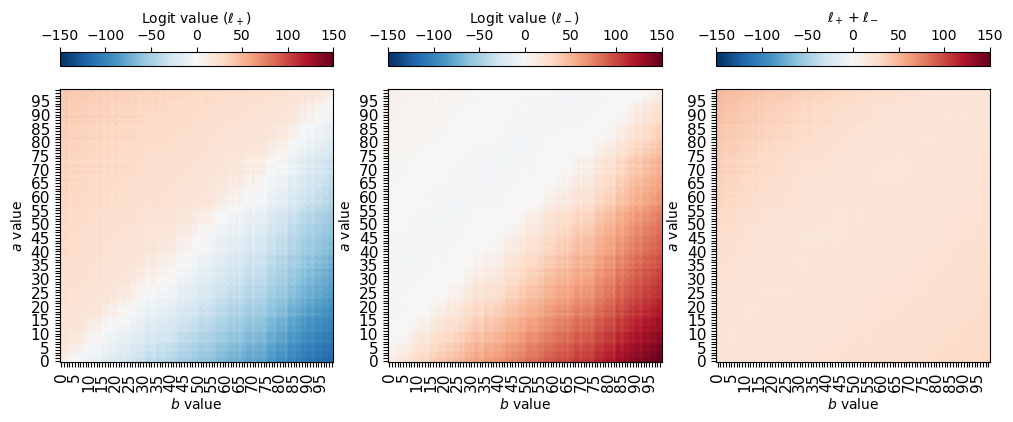

In [25]:
vmin=-150
vmax = 150
fig, axs = plt.subplots(1, 3, figsize=(12,6))
plot = axs[0].imshow(original_logits_sq[:,:,3,tokenizer.get_vocab()['+']].detach().numpy(), cmap='RdBu_r', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
cbar.set_label(r'Logit value ($\ell_+$)')
axs[0].set_ylim(-0.5, 99.5)
axs[0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
axs[0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
axs[0].set_ylabel('$a$ value')
axs[0].set_xlabel('$b$ value')

plot = axs[1].imshow(original_logits_sq[:,:,3,tokenizer.get_vocab()['-']].detach().numpy(), cmap='RdBu_r', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
cbar.set_label(r'Logit value ($\ell_-$)')
axs[1].set_ylim(-0.5, 99.5)
axs[1].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
axs[1].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
axs[1].set_ylabel('$a$ value')
axs[1].set_xlabel('$b$ value')

plot = axs[2].imshow(original_logits_sq[:,:,3,tokenizer.get_vocab()['+']].detach().numpy() + original_logits_sq[:,:,3,tokenizer.get_vocab()['-']].detach().numpy(), cmap='RdBu_r', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
cbar.set_label(r'$\ell_+ + \ell_-$')
axs[2].set_ylim(-0.5, 99.5)
axs[2].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
axs[2].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
axs[2].set_ylabel('$a$ value')
axs[2].set_xlabel('$b$ value')

fig.savefig(figdir/'plus_minus_logits.png', dpi=300)

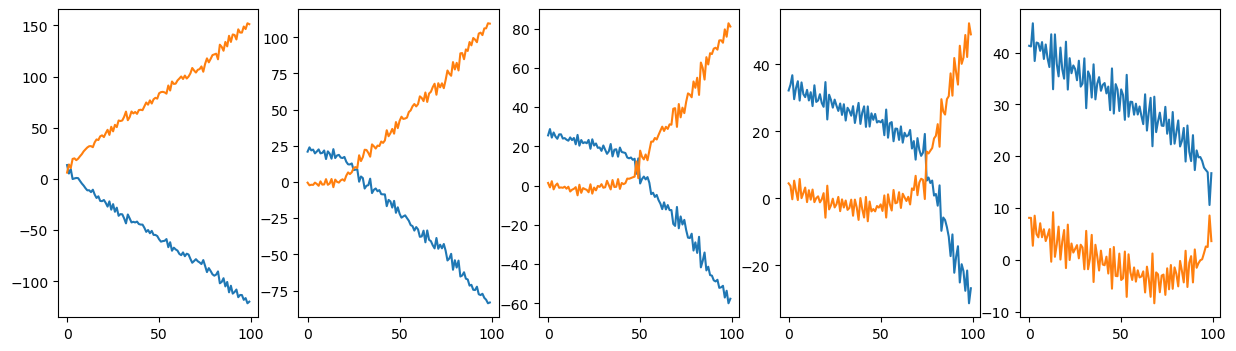

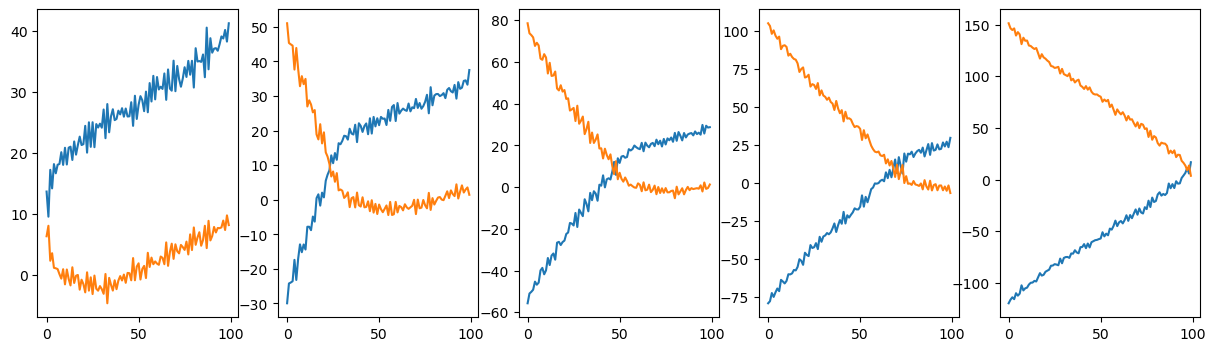

In [26]:
fig, axs = plt.subplots(1,5, figsize=(15,4))
for ax, ind in zip(axs, [0,24,49,74,99]):
    ax.plot(range(100), original_logits_sq[ind,:,3,tokenizer.get_vocab()['+']].detach().numpy(), label='+')
    ax.plot(range(100), original_logits_sq[ind,:,3,tokenizer.get_vocab()['-']].detach().numpy(), label='-')

fig, axs = plt.subplots(1,5, figsize=(15,4))
for ax, ind in zip(axs, [0,24,49,74,99]):
    ax.plot(range(100), original_logits_sq[:,ind,3,tokenizer.get_vocab()['+']].detach().numpy(), label='+')
    ax.plot(range(100), original_logits_sq[:,ind,3,tokenizer.get_vocab()['-']].detach().numpy(), label='-')

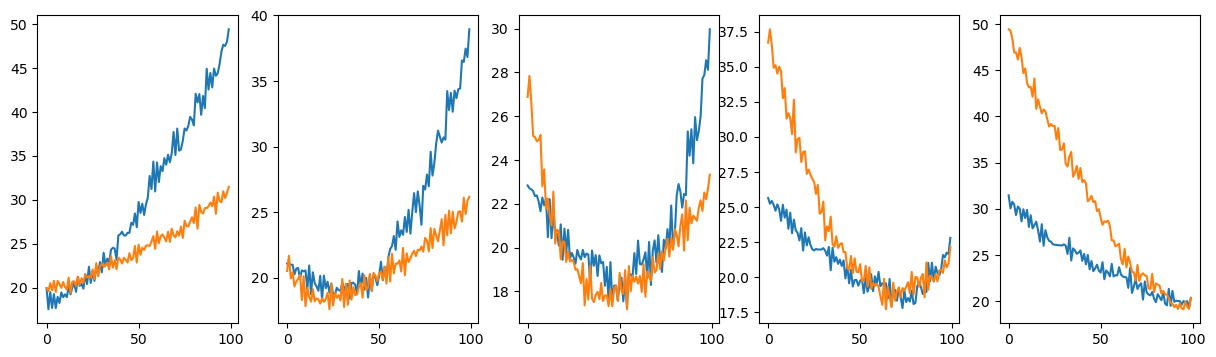

In [27]:
fig, axs = plt.subplots(1,5, figsize=(15,4))
for ax, ind in zip(axs, [0,24,49,74,99]):
    ax.plot(range(100), original_logits_sq[:,ind,3,tokenizer.get_vocab()['+']].detach().numpy() + original_logits_sq[:,ind,3,tokenizer.get_vocab()['-']].detach().numpy(), label='+')
    ax.plot(range(100), original_logits_sq[ind,:,3,tokenizer.get_vocab()['+']].detach().numpy() + original_logits_sq[ind,:,3,tokenizer.get_vocab()['-']].detach().numpy(), label='+')

# Neuron Activations

In [28]:
attn_mat = cache['pattern', 0, 'attn'][:,:,-3,:]
neuron_acts_pre = cache['blocks.0.mlp.hook_pre'][:,-3]
neuron_acts_post = cache['blocks.0.mlp.hook_post'][:,-3]
print(neuron_acts_post.shape)
neuron_acts_post_sq = einops.rearrange(neuron_acts_post, "(x y) d_mlp -> x y d_mlp", x=100)
neuron_acts_pre_sq = einops.rearrange(neuron_acts_pre, "(x y) d_mlp -> x y d_mlp", x=100)

posmask = data.tok[:,-2] == 100
negmask = data.tok[:,-2] == 101

posmask_sq = einops.rearrange(posmask.numpy(), "(x y) -> x y ", x=100)[:,:,None,None]
negmask_sq = einops.rearrange(negmask.numpy(), "(x y) -> x y ", x=100)[:,:,None,None]
print(posmask_sq.shape, posmask.sum(), negmask.sum())

torch.Size([10000, 512])
(100, 100, 1, 1) tensor(5050) tensor(4950)


In [29]:
def plot_neuronact(pos: int):
    clear_output()
    data = neuron_acts_pre_sq.detach().numpy()[:,:,pos]
    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    minmax = np.abs(data).max()
    plot = axs[0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0].set_ylim(-0.5, 99.5)
    axs[0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[0].set_xlabel(r'$b$ value')
    axs[0].set_ylabel(r'$a$ value')
    
    plot = axs[1].imshow(np.log10(power), cmap='magma', vmin=0)#, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} log10 power'.format(pos))
    axs[1].set_ylim(-0.5, 99.5)
    axs[1].set_yticks(range(100));
    axs[1].set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
    axs[1].set_xticks(range(100));
    axs[1].set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
    axs[1].set_xlabel(r'$b$ frequency')
    axs[1].set_ylabel(r'$a$ frequency')
    
interact(plot_neuronact, pos=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact(pos: int)>

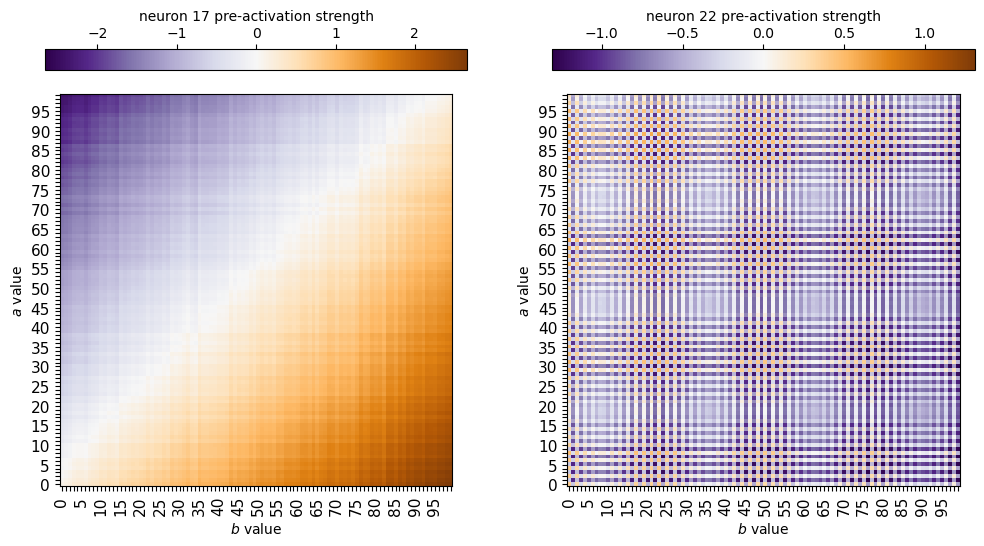

In [30]:
#plot sample neurons

fig, axs = plt.subplots(1, 2, figsize=(12,6))

neurons = [17, 22]
for i, n in enumerate(neurons):
    neur = neuron_acts_pre_sq.detach().numpy()[:,:,n]
    minmax = np.abs(neur).max()
    plot = axs[i].imshow(neur, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} pre-activation strength'.format(n))
    axs[i].set_ylim(-0.5, 99.5)
    axs[i].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[i].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[i].set_xlabel(r'$b$ value')
    axs[i].set_ylabel(r'$a$ value')

fig.savefig(figdir/'sample_neurons.png', dpi=300)

### Fit a simple linear trend to each neuron

Many neurons demonstrate a linear gradient from where $a >> b$ to where $b >> a$. Probably in terms of $a-$ and $b-$ space, this can be described in terms of a linear function $P(a,b) = c_1 (a-b) + c_3)$. Let's fit that function to each neuron and look at the fits.

In [31]:
def linfit(ab, c1, c2):
    a, b = ab
    return (c1*(a-b) + c2).ravel()

#start with neuron 17 -- it's a nice example.
neuron_17 =  neuron_acts_pre_sq.detach().numpy()[:,:,17]
avals = np.arange(100, dtype=float)
bvals = np.arange(100, dtype=float)
bb, aa = np.meshgrid(bvals, avals)



guess = (1., 0.)
popt, pcov = curve_fit(linfit, (aa,bb), neuron_17.ravel())#, p0=guess)
print(popt, pcov)

[-0.02408113  0.12580196] [[ 2.75174194e-10 -1.87338755e-17]
 [-1.87338755e-17  4.58577812e-07]]


In [32]:
def plot_neuronact_fit(pos: int):
    clear_output()
    data = neuron_acts_pre_sq.detach().numpy()[:,:,pos]

    guess = (1., 0.)
    popt, pcov = curve_fit(linfit, (aa,bb), data.ravel())

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    minmax = np.abs(data).max()
    plot = axs[0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0].set_ylim(-0.5, 99.5)
    axs[0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[0].set_xlabel(r'$b$ value')
    axs[0].set_ylabel(r'$a$ value')
    
    plot = axs[1].imshow(linfit((aa,bb), *popt).reshape(100,100), cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'fit with $c_1=${:.5f} and $c_2=${:.5f}'.format(*popt))
    axs[1].set_ylim(-0.5, 99.5)
    axs[1].set_yticks(range(100));
    axs[1].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[1].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[1].set_xlabel(r'$b$ value')
    axs[1].set_ylabel(r'$a$ value')
    
interact(plot_neuronact_fit, pos=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact_fit(pos: int)>

### Fit each neuron and filter between those with a strong linear feature and those without.

In [33]:
fits = np.zeros((neuron_acts_pre_sq.shape[-1],2))
for i in range(fits.shape[0]):
    guess = (0.1, 0.)
    popt, pcov = curve_fit(linfit, (aa,bb), neuron_acts_pre_sq.detach().numpy()[:,:,i].ravel())
    fits[i,:] = popt

In [34]:
cutoff = 1e-3
# TODO: make this more sophisticated -- include the amount that the neurons change the logits by.
important_neurons = np.where(np.abs(fits[:,0]) >= cutoff)[0]
unimportant_neurons = np.where(np.abs(fits[:,0]) < cutoff)[0]
print(important_neurons, len(important_neurons))

[  0   4   5   6   7   9  10  12  13  16  17  18  19  22  24  26  30  31
  32  33  35  36  38  40  42  44  46  50  52  53  55  57  59  60  61  62
  64  65  66  68  69  70  72  77  78  79  83  86  87  88  94  95  97  98
  99 101 102 103 105 106 107 108 109 110 112 113 114 116 117 118 119 124
 131 132 133 135 137 138 139 140 141 142 145 146 148 149 150 152 154 155
 157 158 159 161 162 164 166 172 177 178 180 181 184 185 189 190 195 196
 198 200 202 203 205 207 209 210 212 213 215 217 219 221 222 223 227 228
 229 230 232 234 238 242 243 244 245 251 253 254 255 257 258 259 261 262
 266 272 273 274 278 283 284 286 287 288 289 292 293 294 295 296 297 298
 299 304 305 308 309 312 314 315 316 317 319 321 322 323 325 326 327 330
 332 334 335 337 339 340 345 347 348 349 353 354 356 357 358 360 369 370
 372 373 375 376 377 379 380 383 386 388 392 393 394 396 403 405 406 408
 412 413 416 420 421 423 426 429 430 431 432 433 434 438 440 441 442 443
 444 445 446 447 450 451 452 455 457 459 460 463 46

In [35]:
# ablate unimportant neurons
def ablate_unimportant_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    neurons[:,:,unimportant_neurons] = 0

ablate_freqs = functools.partial(ablate_unimportant_neurons)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_post"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating unimportant')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating unimportant
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06878731 1.2707916 ], Ablated acc: [98.53 59.91]%


In [36]:
# ablate important neurons
def ablate_important_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    neurons[:,:,important_neurons] = 0

ablate_freqs = functools.partial(ablate_important_neurons)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_post"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating important')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating important
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [3.7850626 4.62507  ], Ablated acc: [12.710001 23.46    ]%


In [37]:
# replace all neurons with simple fit
def replace_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    for ind in range(neurons.shape[-1]):
        neurons[:,3,ind] = t.Tensor(linfit((aa,bb), fits[ind,0], fits[ind,1]))

ablate_freqs = functools.partial(replace_neurons)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('replacing neurons')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

replacing neurons
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.08049031 0.01807367], Ablated acc: [97.93 99.94]%


In [38]:
#Now just plot important ones
W_logit = einops.einsum(tfm.W_out[0], tfm.W_U, "d_mlp d_model, d_model d_vocab -> d_mlp d_vocab")
def plot_neuronact(pos: int):
    clear_output()
    
    # data = neuron_acts_pre_sq.detach().numpy()[:,:,important_neurons[pos]]
    data = neuron_acts_post_sq.detach().numpy()[:,:,important_neurons[pos]]
    ft2d = np.fft.fft2(data)
    freqs = np.fft.fftfreq(100)
    power = (ft2d*np.conj(ft2d)).real

    logit_stuff = W_logit[important_neurons[pos], :]
    plus_logit_mul = logit_stuff[tokenizer.get_vocab()['+']]
    minus_logit_mul = logit_stuff[tokenizer.get_vocab()['-']]
    print(f'plus logit: {plus_logit_mul:.3f}, minus_logit: {minus_logit_mul:.3f}')

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    plot = axs[0].imshow(data, cmap='magma', vmin=0)#, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'neuron activation strength {}'.format(important_neurons[pos]))
    axs[0].set_ylim(-0.5, 99.5)
    axs[0].set_yticks(range(100), labels=range(100), size=5.5);
    axs[0].set_xticks(range(100), labels=range(100), size=5.5, rotation='vertical');
    
    plot = axs[1].imshow(np.log10(power), cmap='magma', vmin=0)#, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'neuron log10 power {}'.format(important_neurons[pos]))
    axs[1].set_ylim(-0.5, 99.5)
    axs[1].set_yticks(range(100));
    axs[1].set_yticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5);
    axs[1].set_xticks(range(100));
    axs[1].set_xticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5, rotation='vertical');
    
interact(plot_neuronact, pos=widgets.IntText(value=0, description='Index:'))
#seems like there are a few regular triangular patterns.
#Each of these activations is multiplied by a constant value from W_logit (d_mlp, d_vocab) and summed to get proper logit value for +/-
#TODO: get rid of the ones that are always active.

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact(pos: int)>

ok, very cool. So neuron activations linearly increase (or decrease) from upper left to bottom right on the above plot, aka from a >> b to b >> a in the parameter space. This has some bias so that ReLU() knocks out some portion of parameter space (e.g., all negatives or all positives), and then these get added together to e.g., boost '-' in the bottom right corner (and get rid of '+' there)

Pre-activation (relu) the power spectrum is just like t is coming out of the attention head (makes sense) -- big spread from low freq. The relu then step-function zeros a bunch of stuff, and that sprays stuff to higher frequency.

# Directions in W_logit

angle between +/- (out of pi): 0.8286102427663868


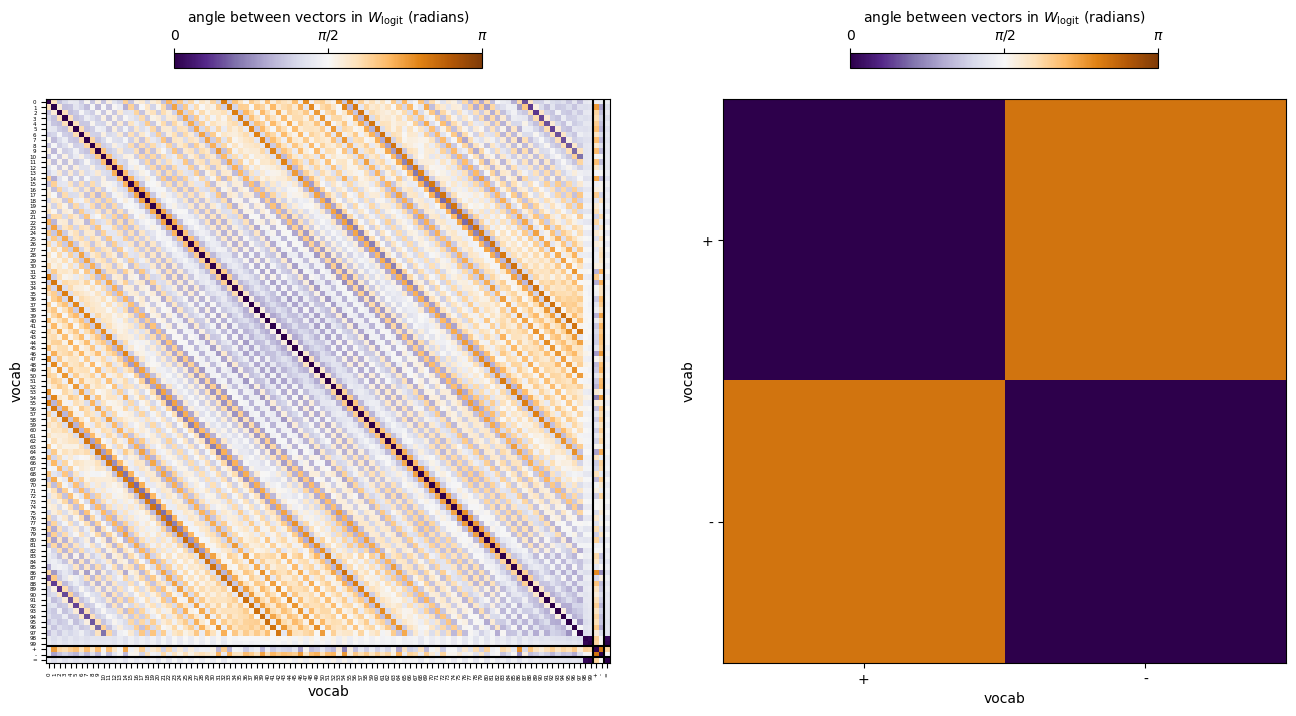

In [39]:
fig,axs = plt.subplots(1,2, figsize=(16, 8))
vocab = [s.replace(' ', '_') for s in tokenizer.convert_ids_to_tokens(range(d_vocab))]
angles = np.zeros((d_vocab,d_vocab))
Wlog = W_logit.detach().numpy()
for i in range(d_vocab):
    for j in range(d_vocab):
        if i == j:
            angles[i,j] = 0
        else:
            angles[i,j] = np.arccos(np.sum(Wlog[:,i]*Wlog[:,j])/(np.sqrt(np.sum(Wlog[:,i]**2)) * np.sqrt(np.sum(Wlog[:,j]**2))))
print('angle between +/- (out of pi): {}'.format(angles[tokenizer.get_vocab()['+'], tokenizer.get_vocab()['-']]/np.pi))

pic = axs[0].imshow(angles, cmap='PuOr_r', vmin=0, vmax=np.pi)
cbar = plt.colorbar(pic, orientation='horizontal', location='top', fraction=0.025)
cbar.set_label(r'angle between vectors in $W_{\rm logit}$ (radians)')
cbar.set_ticks((0, np.pi/2, np.pi))
cbar.set_ticklabels((0, r'$\pi/2$', r'$\pi$'))
axs[0].set_ylabel('vocab')
axs[0].set_xlabel('vocab')
axs[0].axhline(99.5, c='k')
axs[0].axvline(99.5, c='k')
axs[0].axhline(101.5, c='k')
axs[0].axvline(101.5, c='k')
axs[0].set_yticks(range(d_vocab));
axs[0].set_xticks(range(d_vocab));
axs[0].set_xticklabels(vocab, rotation='vertical', fontsize=4);
axs[0].set_yticklabels(vocab, fontsize=4);

pic = axs[1].imshow(angles[-3:-1,-3:-1], cmap='PuOr_r', vmin=0, vmax=np.pi)
cbar = plt.colorbar(pic, orientation='horizontal', location='top', fraction=0.025)
cbar.set_label(r'angle between vectors in $W_{\rm logit}$ (radians)')
cbar.set_ticks((0, np.pi/2, np.pi))
cbar.set_ticklabels((0, r'$\pi/2$', r'$\pi$'))
plt.ylabel('vocab')
plt.xlabel('vocab')
axs[1].set_xticks((0, 1), labels=(vocab[100], vocab[101]));
axs[1].set_yticks((0, 1), labels=(vocab[100], vocab[101]));

fig.savefig(figdir/'wlogit_angles.png', dpi=300, bbox_inches='tight')

[[0.         2.60315585]
 [2.60315585 0.        ]]


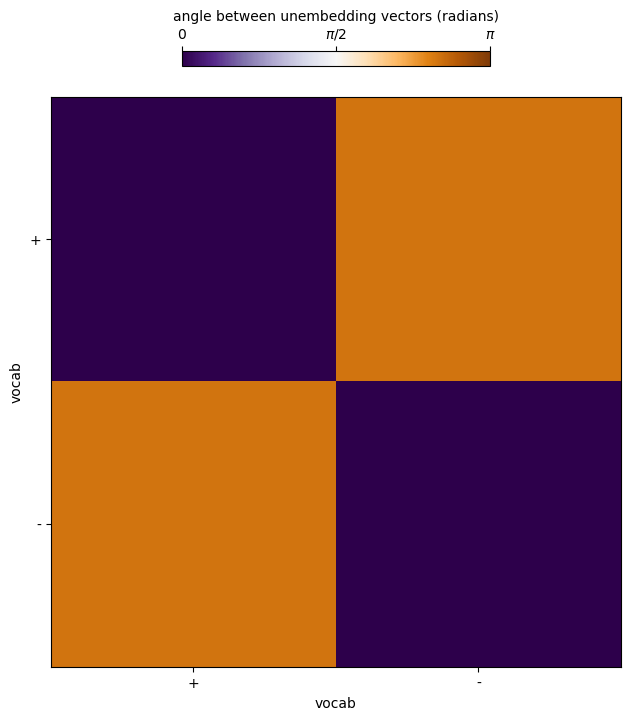

In [40]:
fig,ax = plt.subplots(1,1, figsize=(8, 8))
pic = ax.imshow(angles[-3:-1,-3:-1], cmap='PuOr_r', vmin=0, vmax=np.pi)
print(angles[-3:-1,-3:-1])
cbar = plt.colorbar(pic, orientation='horizontal', location='top', fraction=0.025)
cbar.set_label('angle between unembedding vectors (radians)')
cbar.set_ticks((0, np.pi/2, np.pi))
cbar.set_ticklabels((0, r'$\pi/2$', r'$\pi$'))
plt.ylabel('vocab')
plt.xlabel('vocab')
ax.set_xticks((0, 1), labels=(vocab[100], vocab[101]));
ax.set_yticks((0, 1), labels=(vocab[100], vocab[101]));
fig.savefig(figdir/'wlogit_angles_zoom.png', dpi=300, bbox_inches='tight')

angle between +/- (out of pi): 0.8306796383029191


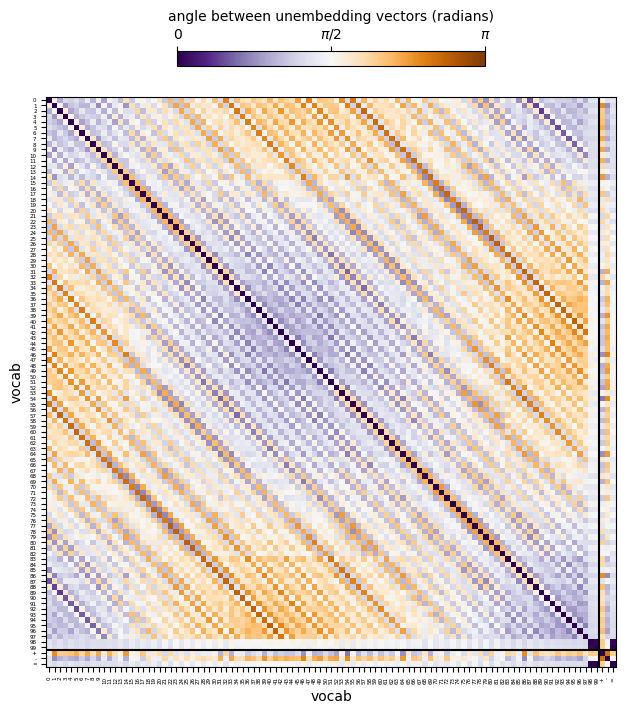

In [41]:
#now do the same but only for important neurons.
fig,ax = plt.subplots(1,1, figsize=(8, 8))
vocab = [s.replace(' ', '_') for s in tokenizer.convert_ids_to_tokens(range(d_vocab))]
angles = np.zeros((d_vocab,d_vocab))
Wlog = W_logit.detach().numpy()
for i in range(d_vocab):
    for j in range(d_vocab):
        if i == j:
            angles[i,j] = 0
        else:
            angles[i,j] = np.arccos(np.sum(Wlog[important_neurons,i]*Wlog[important_neurons,j])/(np.sqrt(np.sum(Wlog[important_neurons,i]**2)) * np.sqrt(np.sum(Wlog[important_neurons,j]**2))))
print('angle between +/- (out of pi): {}'.format(angles[tokenizer.get_vocab()['+'], tokenizer.get_vocab()['-']]/np.pi))

pic = ax.imshow(angles, cmap='PuOr_r', vmin=0, vmax=np.pi)
cbar = plt.colorbar(pic, orientation='horizontal', location='top', fraction=0.025)
cbar.set_label('angle between unembedding vectors (radians)')
cbar.set_ticks((0, np.pi/2, np.pi))
cbar.set_ticklabels((0, r'$\pi/2$', r'$\pi$'))
plt.ylabel('vocab')
plt.xlabel('vocab')
plt.axhline(99.5, c='k')
plt.axvline(99.5, c='k')
ax.set_yticks(range(d_vocab));
ax.set_xticks(range(d_vocab));
ax.set_xticklabels(vocab, rotation='vertical', fontsize=4);
ax.set_yticklabels(vocab, fontsize=4);
fig.savefig(figdir/'wlogit_angles_important.png', dpi=300, bbox_inches='tight')

# How do different tokens / heads contribute to the neurons?

In [42]:
def plot_neuronact(neuron: int):
    clear_output()
    
    fig, axs = plt.subplots(1, 1, figsize=(6,6))
    for head in range(4):
        plt.plot(W_neur[head,:100,neuron].detach().numpy(), label = f'head={head}')
    plt.legend()
    plt.axhline(0, c='k')
    plt.axvline(50, c='k')
    plt.xlabel('token')
    plt.ylabel('neuron pre-activation strength contribution')
interact(plot_neuronact, neuron=widgets.IntText(value=17, description='Neuron:'))

interactive(children=(IntText(value=17, description='Neuron:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact(neuron: int)>

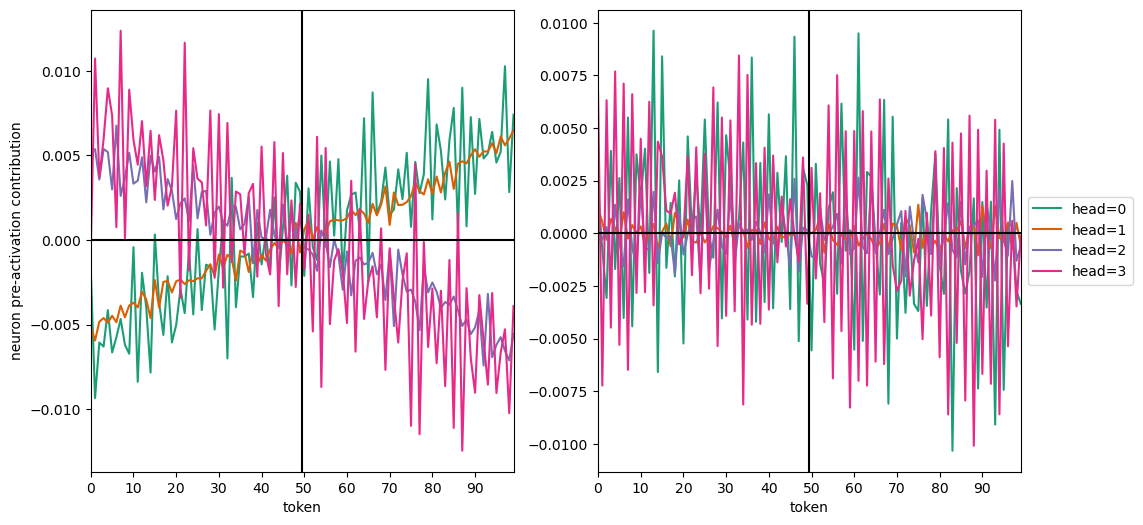

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
for ax in axs:
    ax.set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
for head in range(4):
    axs[0].plot(W_neur[head,:100,17].detach().numpy(), label = f'head={head}')
    axs[1].plot(W_neur[head,:100,22].detach().numpy(), label = f'head={head}')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(2):
    axs[i].axhline(0, c='k')
    axs[i].axvline(49.5, c='k')
    axs[i].set_xticks([i*10 for i in range(10)])
    axs[i].set_xlim(0, 99)
    axs[i].set_xlabel('token')
axs[0].set_ylabel('neuron pre-activation contribution')
fig.savefig(figdir/'token_attention_neuron_contributions.png', dpi=300, bbox_inches='tight')

A given attention head writes something like $n(t) = m t + b + \sum_i A_i \sin(\omega_i t)$ (a line) for a given token in the vocab ($t$) to a neuron $n$.

the slope for heads 0 and 1 for the line component is always the same sign, and the same is true for heads 2 and 3, but (0,1) have the opposite sign slope (maybe negative slope) compared to (2,3).

(0,1) attend to token $a$, and (2,3) attend to token $b$ (still need to prove this), so this is how we get a function like $c_1(a-b) + c2$ for our neuron activations.

### What are the linear fits? Are they always closely tied together for a given neuron?

In [44]:
var_exp = []
fits = []
for neuron in range(512):
    variance_explained = []
    thesefits = []
    for head in range(4):
        fit = np.polyfit(range(100), W_neur[head,:100,neuron].detach().numpy(), deg=1)
        thesefits.append(fit)
        line = p = np.poly1d(fit)(np.arange(100))
        var = (W_neur[head,:100,neuron].detach().numpy()**2).sum()
        noline_var = ((W_neur[head,:100,neuron].detach().numpy() - line)**2).sum()
        variance_explained.append((1 - noline_var/var))
    var_exp.append(variance_explained)
    fits.append(thesefits)
fits = np.array(fits)
var_exp = np.array(var_exp)
print(var_exp[important_neurons].mean(axis=0), var_exp[17], var_exp[22])
print(fits[17])

[0.32254187 0.67522294 0.5628708  0.34325185] [0.67968899 0.9708435  0.88900252 0.53411084] [0.05460413 0.02068272 0.00218633 0.04377875]
[[ 0.00012736 -0.00583914]
 [ 0.00010765 -0.00505324]
 [-0.00010979  0.00513695]
 [-0.00014101  0.00667529]]


# Attention Patterns

In [45]:
prob = np.random.randint(0, int(1e4))
toks = data.tok[prob]
tokens = tfm.to_str_tokens(toks)

attn_patt = cache['pattern', 0, 'attn'][prob]

html = cv.attention.attention_patterns(
    tokens=tokens,
    attention=attn_patt,
)

display(html)

## What is the probability distribution of the attention value of each head at position 0 and 2 on the = sign?

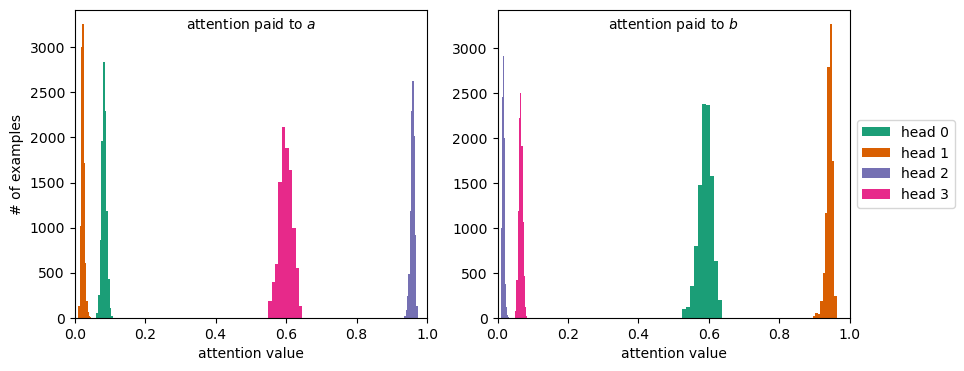

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, ax in enumerate(axs):
    ax.set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    ax.set_xlabel('attention value')
    axs[i].text(0.5, 0.95, 'attention paid to ${}$'.format('a' if i == 0 else 'b'), transform=axs[i].transAxes, ha='center', va='center')
    ax.set_xlim(0, 1)
    
attn_patt = cache['pattern', 0, 'attn']
attn_on_a = attn_patt[:,:,3,0]
attn_on_b = attn_patt[:,:,3,2]
for i in range(attn_on_a.shape[-1]):
    axs[0].hist(attn_on_a[:,i])
    axs[1].hist(attn_on_b[:,i], label='head {}'.format(i))
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_ylabel('# of examples')
fig.savefig(figdir/'attention_hists.png', dpi=300, bbox_inches='tight')

# What do the biases do?

In [47]:
def ablate_embed_hook(
    embedding: Float[Tensor, "batch seq d_model"],
    hook: HookPoint,
) -> Float[Tensor, "batch seq d_model"]:
    embedding[:,0,:] = 0
    embedding[:,2,:] = 0


ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("embed"), approx_posembed_hook)
            ])
print(ablated_logits[:,3,tokenizer.get_vocab()['+']].mean(), ablated_logits[:,3,tokenizer.get_vocab()['-']].mean())
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating a and b')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

tensor(18.6633, grad_fn=<MeanBackward0>) tensor(6.2125, grad_fn=<MeanBackward0>)
Ablating a and b
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 6.163118 51.389286], Ablated acc: [50.5  0. ]%


In [48]:
neuron_acts_centered = neuron_acts_post_sq - neuron_acts_post_sq.mean((0,1),keepdim=True)
# neuron_acts_centered = neuron_acts_pre_sq - neuron_acts_pre_sq.mean((0,1),keepdim=True)
ft_acts = fft2d(neuron_acts_centered)


kfreqs = t.Tensor([ 1, 33, 39, 48]).to(t.int)


square_of_all_terms = einops.reduce(
        ft_acts.pow(2),
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )
square_of_all_terms[square_of_all_terms < 1e-16] = 1e-16

power = (ft_acts**2).sum(axis=-1)

# power = (ft_acts**2/square_of_all_terms[None,None,:]).sum(axis=-1)

# print(f'power before {power.sum():.3e}')
# power[0,:] = 1e-8
# power[:,0] = 1e-8
# print(f'power after like-terms {power.sum():.3e}')
# for f in kfreqs:
#     power[2*f-1,:] = 1e-8
#     power[2*f,:] = 1e-8
#     power[:,2*f-1] = 1e-8
#     power[:,2*f] = 1e-8
# print(f'power after {power.sum():.3e}')
# print(1.058e6/3.438e6)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
axs = [ax,]
plot = axs[0].imshow(np.log10(power[:-1,:-1]), cmap='plasma', vmin=-3, vmax=5)
cbar = plt.colorbar(plot, fraction=0.1)
cbar.set_label(r'$\log_{10}(\rm{Power})$ (summed over neurons)')
axs[0].set_ylim(-0.5, 98.5)
axs[0].set_yticks(range(99));
axs[0].set_yticklabels(fourier_basis_names, fontsize=5);
axs[0].set_xticks(range(99));
axs[0].set_xticklabels(fourier_basis_names, fontsize=5, rotation='vertical');
axs[0].set_ylabel('batch dimension 1 (a varies)')
axs[0].set_xlabel('batch dimension 2 (b varies)')
fig.savefig(figdir/'neuron_post_power_sum.png', dpi=300)

NameError: name 'fft2d' is not defined

In [ ]:
mask = posmask_sq[:,:,:,0]
mask = negmask_sq[:,:,:,0]
mask = 1

neuron_acts_centered = neuron_acts_post_sq - neuron_acts_post_sq.mean((0,1),keepdim=True)
ft_acts = np.fft.fft2(mask*neuron_acts_centered.detach().numpy(), axes=[0,1])
# print('constant term: {}'.format(ft_acts[0,0]))


kfreqs = t.Tensor([ 1, 33, 39, 48]).to(t.int)


square_of_all_terms = einops.reduce(
        np.conj(ft_acts)*ft_acts,
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )
square_of_all_terms[square_of_all_terms < 1e-16] = 1e-16

power = (np.conj(ft_acts)*ft_acts).real.sum(axis=-1)
phase = ft_acts.imag / ft_acts.real
# print(phase)

# power = (ft_acts**2/square_of_all_terms[None,None,:]).sum(axis=-1)

# print(f'power before {power.sum():.3e}')
# power[0,:] = 1e-8
# power[:,0] = 1e-8
# print(f'power after like-terms {power.sum():.3e}')
# for f in kfreqs:
#     power[2*f-1,:] = 1e-8
#     power[2*f,:] = 1e-8
#     power[:,2*f-1] = 1e-8
#     power[:,2*f] = 1e-8
# print(f'power after {power.sum():.3e}')
# print(1.058e6/3.438e6)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
axs = [ax,]
plot = axs[0].imshow(np.log10(power), cmap='plasma', vmin=2, vmax=10)
cbar = plt.colorbar(plot, fraction=0.1)
cbar.set_label(r'$\log_{10}(\rm{Power})$ (summed over neurons)')
axs[0].set_ylim(-0.5, 99.5)
axs[0].set_yticks(range(100));
axs[0].set_yticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5);
axs[0].set_xticks(range(100));
axs[0].set_xticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5, rotation='vertical');
axs[0].set_ylabel('batch dimension 1 (a varies)')
axs[0].set_xlabel('batch dimension 2 (b varies)')
fig.savefig(figdir/'neuron_post_power_sum.png', dpi=300)

In [ ]:
# The terms have amplitude like 1/f.
plt.plot(freqs, np.sqrt(power[0,:]), c='green', lw=2)
plt.plot(freqs, np.sqrt(power[:,0]), c='purple', lw=1)
plt.ylim(1e3, 1e5)
plt.xlim(0, 0.5)
print(freqs)
x = np.linspace(0.01, 0.5, 100)
plt.plot(freqs, 6e4*(0.01/freqs)**1, c='orange', lw=0.5)

In [ ]:
def arrange_by_2d_freqs(tensor):
    '''
    Takes a tensor of shape (p, p, ...) and returns a tensor of shape
    (p//2 - 1, 3, 3, ...) representing the Fourier coefficients sorted by
    frequency (each slice contains const, linear and quadratic terms).

    In other words, if the first two dimensions of the original tensor
    correspond to indexing by 2D Fourier frequencies as follows:

        1           cos(w_1*x)            sin(w_1*x)           ...
        cos(w_1*y)  cos(w_1*x)cos(w_1*y)  sin(w_1*x)cos(w_1*y) ...
        sin(w_1*y)  cos(w_1*x)sin(w_1*y)  sin(w_1*x)sin(w_1*y) ...
        cos(w_2*y)  cos(w_1*x)cos(w_2*y)  sin(w_1*x)cos(w_2*y) ...
        ...

    Then the (k-1)-th slice of the new tensor are the terms corresponding to
    the following 2D Fourier frequencies:

        1           cos(w_k*x)            sin(w_k*x)           ...
        cos(w_k*y)  cos(w_k*x)cos(w_k*y)  sin(w_k*x)cos(w_k*y) ...
        sin(w_k*y)  cos(w_k*x)sin(w_k*y)  sin(w_k*x)sin(w_k*y) ...

    for k = 1, 2, ..., p//2.

    Note we omit the constant term, i.e. the 0th slice has frequency k=1.
    '''
    idx_2d_y_all = []
    idx_2d_x_all = []
    for freq in range(1, 100//2):
        idx_1d = [0, 2*freq-1, 2*freq]
        idx_2d_x_all.append([idx_1d for _ in range(3)])
        idx_2d_y_all.append([[i]*3 for i in idx_1d])
    # print(idx_2d_x_all)
    return tensor[idx_2d_y_all, idx_2d_x_all]


def find_neuron_freqs(
    fourier_neuron_acts: Float[Tensor, "p p d_mlp"],
    top_k : int = 1
) -> Tuple[Float[Tensor, "d_mlp"], Float[Tensor, "d_mlp"]]:
    '''
    Returns the tensors `neuron_freqs` and `neuron_frac_explained`,
    containing the frequencies that explain the most variance of each
    neuron and the fraction of variance explained, respectively.
    '''
    fourier_neuron_acts_by_freq = arrange_by_2d_freqs(fourier_neuron_acts)
    assert fourier_neuron_acts_by_freq.shape == (100//2-1, 3, 3, d_mlp)

    # Sum squares of all frequency coeffs, for each neuron
    square_of_all_terms = einops.reduce(
        fourier_neuron_acts.pow(2),
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )

    # Sum squares just corresponding to const+linear+quadratic terms,
    # for each frequency, for each neuron
    square_of_each_freq = einops.reduce(
        fourier_neuron_acts_by_freq.pow(2),
        "freq x_coeff y_coeff neuron -> freq neuron",
        "sum"
    )

    if top_k == 1:
        # Find the freq explaining most variance for each neuron
        # (and the fraction of variance explained)
        neuron_variance_explained, neuron_freqs = square_of_each_freq.max(0)
        neuron_frac_explained = neuron_variance_explained / square_of_all_terms
    
        # The actual frequencies count up from k=1, not 0!
        neuron_freqs += 1
        return neuron_freqs, neuron_frac_explained
    else:
        # Find the freq explaining most variance for each neuron
        # (and the fraction of variance explained)
        neuron_variance_explained, neuron_freqs = square_of_each_freq.topk(top_k,dim=0)
        neuron_frac_explained = neuron_variance_explained.sum(dim=0) / square_of_all_terms
    
        # The actual frequencies count up from k=1, not 0!
        neuron_freqs += 1
        return neuron_freqs, neuron_frac_explained
        
        

neuron_freqs, neuron_frac_explained = find_neuron_freqs(t.Tensor(ft_acts), top_k=1)
key_freqs, neuron_freq_counts = t.unique(t.sort(neuron_freqs).values, return_counts=True)#, dim=1)

print('key frequencies: ', key_freqs)

In [ ]:
plt.scatter(neuron_freqs, neuron_frac_explained)

Only up to half of the power is contained in these 'like' terms (w_k with w_k). Turns out this half of the power is entirely in terms like cos(w_k) or sin(w_k). 

What happens if, for each neuron, we sample all the power in all the terms of its maximum frequency -- what happens then?

In [ ]:
def check_neuron_power(
    fourier_neuron_acts: Float[Tensor, "p p d_mlp"],
    neuron_freqs: Int[Tensor, "d_mlp"],
) -> Tuple[Float[Tensor, "d_mlp"], Float[Tensor, "d_mlp"]]:
    # Sum squares of all frequency coeffs, for each neuron
    square_of_all_terms = einops.reduce(
        fourier_neuron_acts.pow(2),
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )
    pow = fourier_neuron_acts.pow(2)

    neuron_pow = t.zeros(neuron_freqs.shape[0])
    for i,f in enumerate(neuron_freqs):
        for j in (2*f-1, 2*f):
            neuron_pow[i] += pow[j,:,i].sum()
            neuron_pow[i] += pow[:,j,i].sum()
            for k in (2*f-1, 2*f):
                neuron_pow[i] -= pow[j,k,i] #fix the four places where the rows/columns overlap

    return neuron_pow / square_of_all_terms
frac_explained = check_neuron_power(t.Tensor(ft_acts), neuron_freqs)

plt.scatter(neuron_freqs, frac_explained)
plt.xlabel("Neuron Dominant frequency")
plt.ylabel("fraction of neuron power in dominant frequency")

### Ablate unimportant frequencies for each head
Now we're going to write a hook to fourier transform the data, remove all frequencies except the most important one for each head, then transform back into 

In [ ]:
freqs = np.fft.fftfreq(100)
key_freq_inds = []
for f1 in key_freqs:
    for i, f2 in enumerate(freqs):
        if np.abs(f2) == f1/100:
            key_freq_inds.append(i)
# neuron_freq_inds = t.Tensor([[i for i, f1 in enumerate(freqs) if np.abs(f1) == f2/100] for f2 in neuron_freqs]).to(t.int)
print(key_freq_inds)

In [ ]:
def crossfreq_ablation_hook(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint,
    seq_ind: int = -2
) -> Float[Tensor, "batch seq d_mlp"]:
    
    neuron_acts_post_sq = einops.rearrange(neurons[:,seq_ind,:], "(x y) d_mlp -> x y d_mlp", x=100)
    ft = np.fft.fft2(neuron_acts_post_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    N = 50
    new_ft[0,:N,:] = ft[0,:N,:]
    new_ft[:N,0,:] = ft[:N,0,:]
    new_ft[0,-N+1:,:] = ft[0,-N+1:,:]
    new_ft[-N+1:,0,:] = ft[-N+1:,0,:]
    # for k in key_freq_inds:
    #     new_ft[0,k,:] = ft[0,k,:]
    #     new_ft[k,0,:] = ft[k,0,:]
    acts = np.fft.ifft2(new_ft, axes=[0,1]).real
    neuron_acts_post_sq[:] = t.Tensor(acts)
    neurons[:,seq_ind,:] = einops.rearrange(neuron_acts_post_sq, "x y d_mlp -> (x y) d_mlp")


ablate_freqs = functools.partial(crossfreq_ablation_hook, seq_ind=-3)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -3')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_freqs = functools.partial(crossfreq_ablation_hook, seq_ind=-2)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -2')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")


In [ ]:
def simplefreq_ablation_hook(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint,
    seq_ind: int = -2
) -> Float[Tensor, "batch seq d_mlp"]:
    
    neuron_acts_post_sq = einops.rearrange(neurons[:,seq_ind,:], "(x y) d_mlp -> x y d_mlp", x=100)
    ft = np.fft.fft2(neuron_acts_post_sq.detach().numpy(), axes=[0,1])
    ft[0,:,:] = 0
    ft[:,0,:] = 0
    acts = np.fft.ifft2(ft, axes=[0,1]).real
    neuron_acts_post_sq[:] = t.Tensor(acts)
    neurons[:,seq_ind,:] = einops.rearrange(neuron_acts_post_sq, "x y d_mlp -> (x y) d_mlp")


ablate_freqs = functools.partial(simplefreq_ablation_hook, seq_ind=-3)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -3')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_freqs = functools.partial(simplefreq_ablation_hook, seq_ind=-2)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -2')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")
